In [1]:
# Import the necessary python packages
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import csv

# Import datetime
from datetime import datetime

# For kinship and pedigree
import PyAGH
import graphviz

# Import API
import urllib.request, json, csv

# Generate the main dataframe

In [2]:
# Remove birds with no Dam or no Sire
# Define a function that drops rows
def filter_rows_by_values(df, col, values):
    return df[~df[col].isin(values)]

# Use the function:
# data = filter_rows_by_values(data, "sire", [None])

In [3]:
# Import the birds dataset
with urllib.request.urlopen("https://gracula.psyc.virginia.edu/birds/api/pedigree/?species=zebf") as url:
    data = pd.read_json(url)

# Clean up
data["uuid"] = data["uuid"].str[:6]
data["name"] = data["name"].str[5:]
data["sire"] = data["sire"].str[5:]
data["dam"] = data["dam"].str[5:]

# replace 'None' by 'origin' in sire/dam
data["sire"] = data["sire"].replace({None: "Origin"})
data["dam"] = data["dam"].replace({None: "Origin"})

In [4]:
# Import reserved_by
with urllib.request.urlopen("https://gracula.psyc.virginia.edu/birds/api/animals/?reserved_by=melizalab") as url:
    reservation = pd.read_json(url)

reservation = reservation[["uuid", "reserved_by"]]
reservation["uuid"] = reservation["uuid"].str[:6]

reservation = pd.merge(data, reservation, on=["uuid"])
#reservation

In [5]:
# Calculate the age for all the birds
today = datetime.today()

# Convert acquisition into a timestamp
birth = pd.to_datetime(data['acquired_on'])

# Calculate
data["age"] = (today - birth).dt.days

# Convert in 0 & 1
data = data*1

for index, row in data.iterrows():
    if row['alive'] == 0:
        data.at[index, 'age'] = "NA"

#data

/tmp/ipykernel_43365/1539674606.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.at[index, 'age'] = "NA"


In [6]:
alive_birds = []

for index, row in data.iterrows():
    if row['alive'] == 1 :
        alive_birds.append(row)

alive_birds = pd.DataFrame(alive_birds) # Create a DataFrame of alive birds only

#alive_birds

Example of a Fertility Score Calculation (Hypothetical)

An example calculation could use specific thresholds for each factor. Suppose each of the factors contributes a score between 0 to 10, with higher scores representing better fertility potential. The formula might look like this:
F=(10−A)+H+(10−B)+L+M+S
F=(10−A)+H+(10−B)+L+M+S

Where:

    AA = Age (e.g., 30 might yield 7 points, while 40 yields 3 points)
    HH = Hormonal health (based on specific tests)
    BB = BMI (e.g., a BMI of 22 could yield 9 points, and 30 could yield 3 points)
    LL = Lifestyle (e.g., non-smoking, healthy diet = 8 points)
    MM = Medical history (e.g., no conditions = 10 points)
    SS = Semen analysis (e.g., normal sperm count = 10 points)

## Calculate kinship

In [7]:
ped = pd.DataFrame()

ped["id"] = data["name"]
ped["sire"] = data["sire"]
ped["dam"] = data["dam"]

ped = filter_rows_by_values(ped, "sire", ["Origin"]) # Filter out the birds brought from the store
ped

,id,sire,dam
16,blue_20,blue_11,blue_12
17,blue_30,blue_7,blue_13
18,blue_31,blue_7,blue_13
19,blue_34,blue_7,blue_15
20,blue_35,blue_7,blue_15
...,...,...,...
383,f3f7198d,cobalt_379,emerald_1
384,f5035c96,purple_219,emerald_16
385,b80c6f9f,emerald_13,cobalt_397
386,66758628,cobalt_391,emerald_17


In [8]:
ped_selected = PyAGH.selectPed(data=ped, id=["f5035c96"], generation=5) # Print X generations of the chosen bird
ped_selected = PyAGH.sortPed(ped_selected)

ped_selected

,id,sire,dam
0,red_249,0,0
1,purple_92,0,0
2,red_216,0,0
3,red_264,0,0
4,red_192,0,0
5,green_79,0,0
6,purple_89,0,0
7,purple_126,0,0
8,ruby_143,0,0
9,purple_7,0,0


In [9]:
sort_ped = PyAGH.sortPed(ped) # Sort the pedigree first
A = PyAGH.makeA(sort_ped)

In [10]:
coef_inbreeding = PyAGH.coefInbreeding(A)
#coef_inbreeding

In [11]:
coef_kinship = PyAGH.coefKinship(A)
#coef_kinship

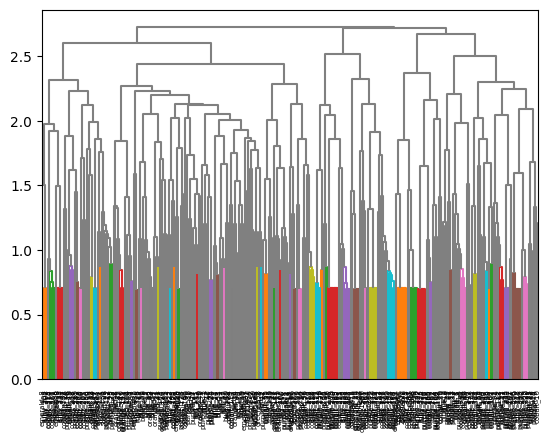

In [12]:
cluster_example = PyAGH.cluster(A)
plt.xticks(rotation=90)
plt.savefig('../output/cluster_example.png', facecolor='w', dpi=300)

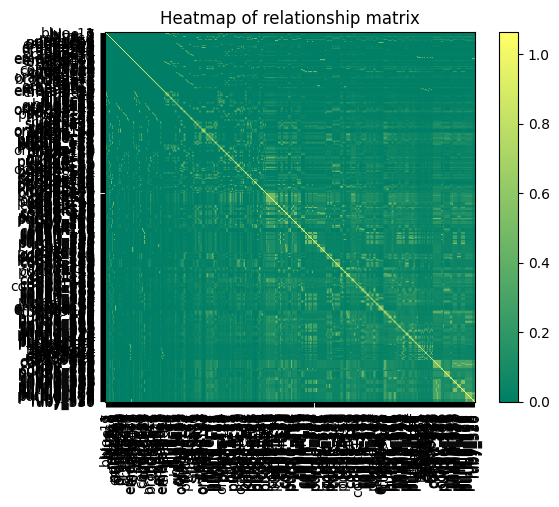

In [13]:
heatmap_example = PyAGH.heat(A)
plt.xticks(rotation=90)
plt.savefig('../output/heatmap_example.png', facecolor='w',dpi=500)

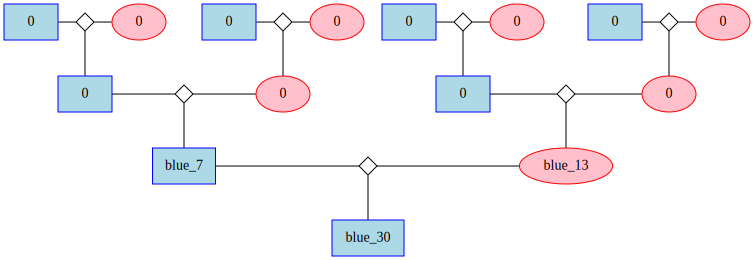

In [14]:
ped_selected = PyAGH.selectPed(data=ped,id=['blue_30'], generation=3) # Print selected number of generation of the bird
p = PyAGH.gragh(ped_selected)
graphviz.Source(p)

# Mastersheet events + birds

In [15]:
# Import the birds used for an experiment
with urllib.request.urlopen("https://gracula.psyc.virginia.edu/birds/api/events/?status=used") as url:
    used_birds = pd.read_json(url)

# Import the birds that died unexpectedly
with urllib.request.urlopen("https://gracula.psyc.virginia.edu/birds/api/events/?status=died") as url:
    died_birds = pd.read_json(url)

#used_birds

In [16]:
# Clean up
used_birds["uuid"] = used_birds["animal"].str[:6]
died_birds["uuid"] = died_birds["animal"].str[:6]

#used_birds

In [17]:
# Add the list of events to the mastersheet
used_birds_ = pd.merge(
    data, used_birds, on=["uuid"]
)

died_birds_ = pd.merge(
    data, died_birds, on=["uuid"]
)

# Concatenate into a mastersheet
frames = [used_birds_, died_birds_]
mastersheet = pd.concat(frames)

In [18]:
#mastersheet

In [19]:
#data

# Add coeff_inbreeding to data

In [20]:
sort_ped = PyAGH.sortPed(ped) # Select all the birds for analysis instead of a given bird
A = PyAGH.makeA(sort_ped)

coef_inbreeding = PyAGH.coefInbreeding(A)
coef_kinship = PyAGH.coefKinship(A)

# Making it shinny
coef_inbreeding["name"] = coef_inbreeding["ID"]
coef_inbreeding["coef_inbreeding"] = coef_inbreeding["F"]
coef_inbreeding = coef_inbreeding[["name", "coef_inbreeding"]]

parent_kinship = pd.DataFrame()

parent_kinship['sire'] = coef_kinship['ID1']
parent_kinship['dam'] = coef_kinship['ID2']
parent_kinship['p_kinship'] = coef_kinship['r']

In [21]:
#parent_kinship

In [22]:
data = pd.merge(
    data, coef_inbreeding, on=["name"]
)

# Filter out birds that were bought from the store
data = filter_rows_by_values(data, "sire", ['Origin'])
data = filter_rows_by_values(data, "sire", ['Origin'])

In [23]:
#data

# Extract the parents kinship

In [24]:
list = pd.DataFrame()

In [25]:
# Test filtering
filtered_df = coef_kinship.loc[coef_kinship['ID1'].eq('cobalt_126') & coef_kinship['ID2'].eq('ruby_236')]
list = pd.concat([list, filtered_df], ignore_index=True)

In [26]:
master = pd.merge(data, parent_kinship, how="left", on=['sire', 'dam'])
#master

# Kinship score

In [27]:
# Calculate the median and the respective quartiles
p_k_mean = master['p_kinship'].mean()
p_k_median = master['p_kinship'].median()

In [28]:
master['p_k_mean'] = p_k_mean

In [29]:
#master

# Extract DATA for a list of birds

In [30]:
input_table = pd.read_csv("../input/list_input.csv")
input_table

,name
0,emerald_21
1,purple_222
2,emerald_6
3,cobalt_315
4,emerald_13
5,cobalt_397
6,emerald_3
7,cobalt_373
8,emerald_15
9,purple_245


In [31]:
# Filter the birds from the input list out of the mastersheet
selected_rows = master[master['name'].isin(input_table['name'])]

# Selected group mean and median
selected_rows['p_group_median'] = selected_rows['p_kinship'].median()
selected_rows['p_group_mean'] = selected_rows['p_kinship'].mean()
selected_rows['p_group_upper'] = selected_rows['p_kinship'].quantile(0.75)
selected_rows['p_group_lower'] = selected_rows['p_kinship'].quantile(0.25)

selected_rows

/tmp/ipykernel_43365/1124657153.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows['p_group_median'] = selected_rows['p_kinship'].median()
/tmp/ipykernel_43365/1124657153.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows['p_group_mean'] = selected_rows['p_kinship'].mean()
/tmp/ipykernel_43365/1124657153.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in th

,uuid,name,sire,dam,sex,alive,plumage,acquired_on,age,coef_inbreeding,p_kinship,p_k_mean,p_group_median,p_group_mean,p_group_upper,p_group_lower
55,9a09b0,cobalt_110,cobalt_57,purple_174,F,1,fawn,2023-01-11,838.0,0.007812,NaN,0.017488,0.024522,0.026317,0.03119,0.000485
58,a9167f,cobalt_122,cobalt_32,ruby_203,M,1,gray,2023-02-09,809.0,-0.000000,NaN,0.017488,0.024522,0.026317,0.03119,0.000485
60,abad48,cobalt_126,cobalt_206,purple_179,M,1,gray,2023-02-21,797.0,0.000000,NaN,0.017488,0.024522,0.026317,0.03119,0.000485
67,d52e8e,cobalt_165,cobalt_80,purple_190,M,1,gray,2023-04-12,747.0,0.000244,0.000485,0.017488,0.024522,0.026317,0.03119,0.000485
71,986382,cobalt_197,cobalt_32,ruby_203,F,1,silver,2023-07-24,644.0,-0.000000,NaN,0.017488,0.024522,0.026317,0.03119,0.000485
76,debe05,cobalt_208,purple_126,purple_122,M,1,gray,2022-06-19,1044.0,-0.000000,NaN,0.017488,0.024522,0.026317,0.03119,0.000485
88,b197b2,cobalt_310,cobalt_247,purple_142,F,1,fawn,2024-02-05,448.0,0.023926,0.047436,0.017488,0.024522,0.026317,0.03119,0.000485
89,aa9442,cobalt_312,cobalt_137,cobalt_245,M,1,gray,2024-02-11,442.0,0.021851,NaN,0.017488,0.024522,0.026317,0.03119,0.000485
90,a23a09,cobalt_314,cobalt_98,cobalt_7,M,1,gray,2024-02-05,448.0,-0.000000,0.000000,0.017488,0.024522,0.026317,0.03119,0.000485
91,cd02e2,cobalt_315,cobalt_98,cobalt_7,F,1,silver,2024-02-05,448.0,-0.000000,0.000000,0.017488,0.024522,0.026317,0.03119,0.000485


# Kinship score relative to the group

A kinship score shall be attributed for each birds according to the parents kinship, with:
- k = 10 when p_kinship = 0
- k = 7 when 0 < p < median
- k = 4 when median < p < upper quartile
- k = 0 when p > upper quartile

In [32]:
# Definition of the function kinship_score
def k_score(row):
    median = row['p_group_median']
    upper = row['p_group_upper']
    if row['p_kinship'] == 0:
        return 10
    elif 0 < row['p_kinship'] < median :
        return 7
    elif median <= row['p_kinship'] <= upper :
        return 4
    elif row['p_kinship'] > upper :
        return 0
    else:
        return "NA"

In [33]:
selected_rows['k_score'] = selected_rows.apply(k_score, axis=1)

/tmp/ipykernel_43365/2606378015.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_rows['k_score'] = selected_rows.apply(k_score, axis=1)


In [34]:
selected_rows

,uuid,name,sire,dam,sex,alive,plumage,acquired_on,age,coef_inbreeding,p_kinship,p_k_mean,p_group_median,p_group_mean,p_group_upper,p_group_lower,k_score
55,9a09b0,cobalt_110,cobalt_57,purple_174,F,1,fawn,2023-01-11,838.0,0.007812,NaN,0.017488,0.024522,0.026317,0.03119,0.000485,NA
58,a9167f,cobalt_122,cobalt_32,ruby_203,M,1,gray,2023-02-09,809.0,-0.000000,NaN,0.017488,0.024522,0.026317,0.03119,0.000485,NA
60,abad48,cobalt_126,cobalt_206,purple_179,M,1,gray,2023-02-21,797.0,0.000000,NaN,0.017488,0.024522,0.026317,0.03119,0.000485,NA
67,d52e8e,cobalt_165,cobalt_80,purple_190,M,1,gray,2023-04-12,747.0,0.000244,0.000485,0.017488,0.024522,0.026317,0.03119,0.000485,7
71,986382,cobalt_197,cobalt_32,ruby_203,F,1,silver,2023-07-24,644.0,-0.000000,NaN,0.017488,0.024522,0.026317,0.03119,0.000485,NA
76,debe05,cobalt_208,purple_126,purple_122,M,1,gray,2022-06-19,1044.0,-0.000000,NaN,0.017488,0.024522,0.026317,0.03119,0.000485,NA
88,b197b2,cobalt_310,cobalt_247,purple_142,F,1,fawn,2024-02-05,448.0,0.023926,0.047436,0.017488,0.024522,0.026317,0.03119,0.000485,0
89,aa9442,cobalt_312,cobalt_137,cobalt_245,M,1,gray,2024-02-11,442.0,0.021851,NaN,0.017488,0.024522,0.026317,0.03119,0.000485,NA
90,a23a09,cobalt_314,cobalt_98,cobalt_7,M,1,gray,2024-02-05,448.0,-0.000000,0.000000,0.017488,0.024522,0.026317,0.03119,0.000485,10
91,cd02e2,cobalt_315,cobalt_98,cobalt_7,F,1,silver,2024-02-05,448.0,-0.000000,0.000000,0.017488,0.024522,0.026317,0.03119,0.000485,10


# Heatmap and cluster for selected birds

In [35]:
list_of_birds = []

for index, row in selected_rows.iterrows():
    bird = row['name']
    list_of_birds.append(bird)

list_of_birds

['cobalt_110',
 'cobalt_122',
 'cobalt_126',
 'cobalt_165',
 'cobalt_197',
 'cobalt_208',
 'cobalt_310',
 'cobalt_312',
 'cobalt_314',
 'cobalt_315',
 'cobalt_326',
 'cobalt_328',
 'cobalt_373',
 'cobalt_379',
 'cobalt_391',
 'cobalt_397',
 'purple_206',
 'purple_219',
 'purple_222',
 'purple_245',
 'ruby_236',
 'ruby_246',
 'ruby_250',
 'ruby_256',
 'ruby_257',
 'ruby_259',
 'ruby_270',
 'ruby_273',
 'ruby_298']

In [36]:
ped_selected = PyAGH.selectPed(data=ped, id=list_of_birds, generation=1) # Print X generations of the chosen bird
ped_selected = PyAGH.sortPed(ped_selected)

In [37]:
sort_ped = PyAGH.sortPed(ped_selected) # Sort the pedigree first
A = PyAGH.makeA(sort_ped)

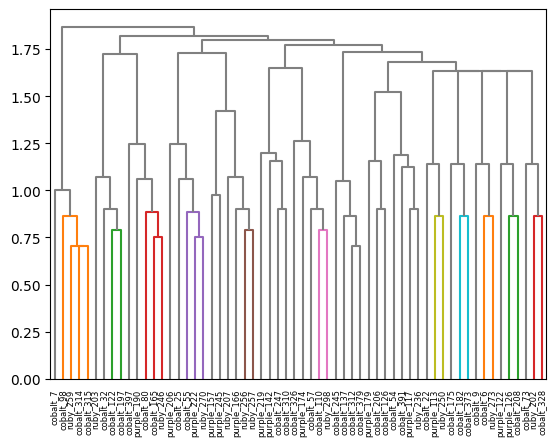

In [38]:
cluster_example = PyAGH.cluster(A)
plt.xticks(rotation=90)
plt.savefig('../output/cluster_selected_birds.png', facecolor='w', dpi=300)

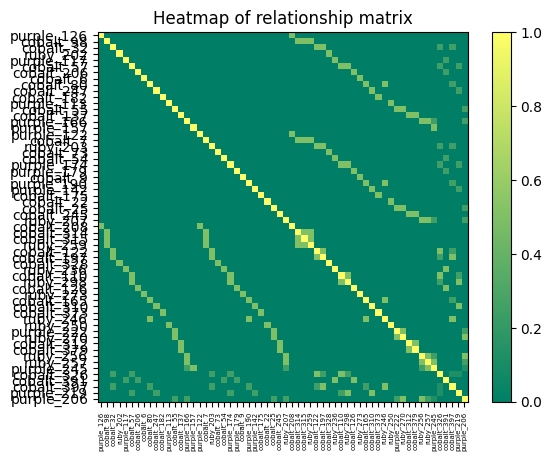

In [49]:
heatmap_example = PyAGH.heat(A)
plt.xticks(rotation=90, size=5)
plt.yticks(size=5)
plt.savefig('../output/heatmap_selected_birds.png', facecolor='w',dpi=500)

# Export tables

In [45]:
master.to_csv("../output/master.csv")
selected_rows.to_csv("../output/selected_birds.csv")

In [47]:
selected_rows

,uuid,name,sire,dam,sex,alive,plumage,acquired_on,age,coef_inbreeding,p_kinship,p_k_mean,p_group_median,p_group_mean,p_group_upper,p_group_lower,k_score
55,9a09b0,cobalt_110,cobalt_57,purple_174,F,1,fawn,2023-01-11,838.0,0.007812,NaN,0.017488,0.024522,0.026317,0.03119,0.000485,NA
58,a9167f,cobalt_122,cobalt_32,ruby_203,M,1,gray,2023-02-09,809.0,-0.000000,NaN,0.017488,0.024522,0.026317,0.03119,0.000485,NA
60,abad48,cobalt_126,cobalt_206,purple_179,M,1,gray,2023-02-21,797.0,0.000000,NaN,0.017488,0.024522,0.026317,0.03119,0.000485,NA
67,d52e8e,cobalt_165,cobalt_80,purple_190,M,1,gray,2023-04-12,747.0,0.000244,0.000485,0.017488,0.024522,0.026317,0.03119,0.000485,7
71,986382,cobalt_197,cobalt_32,ruby_203,F,1,silver,2023-07-24,644.0,-0.000000,NaN,0.017488,0.024522,0.026317,0.03119,0.000485,NA
76,debe05,cobalt_208,purple_126,purple_122,M,1,gray,2022-06-19,1044.0,-0.000000,NaN,0.017488,0.024522,0.026317,0.03119,0.000485,NA
88,b197b2,cobalt_310,cobalt_247,purple_142,F,1,fawn,2024-02-05,448.0,0.023926,0.047436,0.017488,0.024522,0.026317,0.03119,0.000485,0
89,aa9442,cobalt_312,cobalt_137,cobalt_245,M,1,gray,2024-02-11,442.0,0.021851,NaN,0.017488,0.024522,0.026317,0.03119,0.000485,NA
90,a23a09,cobalt_314,cobalt_98,cobalt_7,M,1,gray,2024-02-05,448.0,-0.000000,0.000000,0.017488,0.024522,0.026317,0.03119,0.000485,10
91,cd02e2,cobalt_315,cobalt_98,cobalt_7,F,1,silver,2024-02-05,448.0,-0.000000,0.000000,0.017488,0.024522,0.026317,0.03119,0.000485,10
